In [29]:
import numpy as np
import matplotlib.pyplot as plt
import json
import torchvision
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from helpers.cnn_model import CNNModel

In [30]:
DOWNLOAD_DATA = False

In [31]:
# create a dict with the labels and their respective character as a string
labels_map = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j',
    46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't',
    56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}

# save the labels map as a json file
with open('./EMNIST/labels_map.json', 'w') as f:
    json.dump(labels_map, f)

In [32]:
# PREPARE DATASET
# prepare transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
    torchvision.transforms.Lambda(lambda x: x.transpose(1, 2))
])

# load EMNIST dataset from ./EMNIST/EMNIST/raw folder
data_train = torchvision.datasets.EMNIST(root='./EMNIST', split='byclass', train=True, download=DOWNLOAD_DATA, transform=transform)
data_test = torchvision.datasets.EMNIST(root='./EMNIST', split='byclass', train=False, download=DOWNLOAD_DATA, transform=transform)

# remove samples with label 36-61 (lowercase letters) to only keep uppercase letters and digits relevant for the license plates
indices_train = [i for i, (_, label) in enumerate(data_train) if label < 36]
data_train_filtered = torch.utils.data.Subset(data_train, indices_train)
indices_test = [i for i, (_, label) in enumerate(data_test) if label < 36]
data_test_filtered = torch.utils.data.Subset(data_test, indices_test)

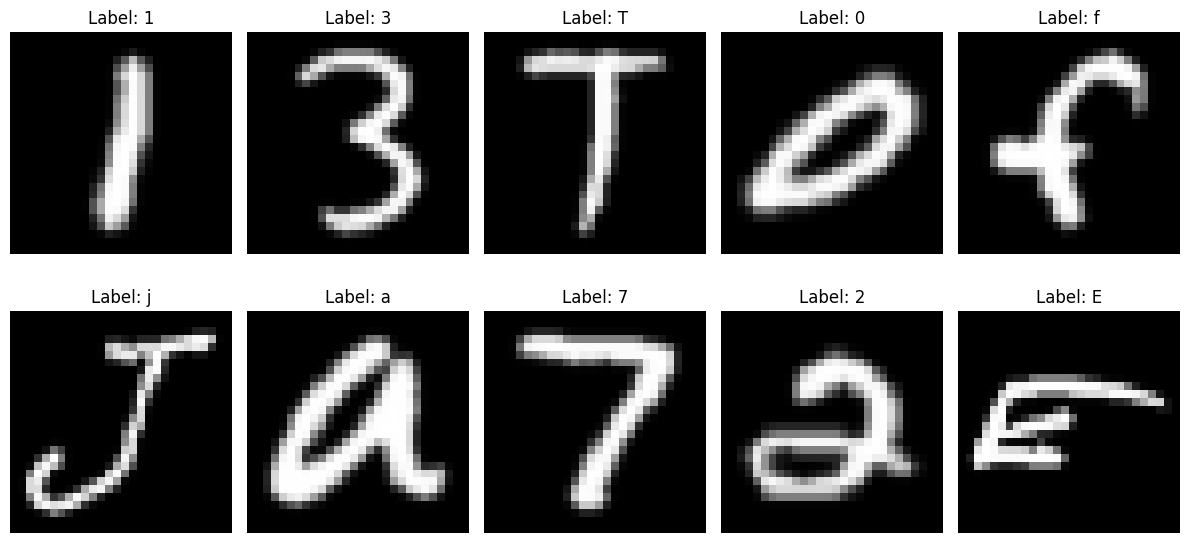

In [33]:
# inspect dataset by plotting some samples
indices = np.random.choice(len(data_train), 10, replace=False)
samples = [data_train[i] for i in indices]

# Plot the samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i, (image, label) in enumerate(samples):
    # Denormalize the image
    image = image.numpy().squeeze()
    image = (image * 0.5) + 0.5  # Reverse normalization
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {labels_map[label]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [34]:
# create data loaders for training, validation and testing
# validations split: 20% of training data

train_size = int(0.8 * len(data_train_filtered))
val_size = len(data_train_filtered) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data_train_filtered, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test_filtered, batch_size=64, shuffle=False)

In [35]:
def training_loop(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improvement_epochs = 0
    patience = 5  # number of epochs to wait for improvement before stopping

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_epochs = 0

        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print("Early stopping triggered")

            # load the best model
            model.load_state_dict(torch.load('best_model.pth'))
            break 

    return train_losses, val_losses, val_accuracies

In [36]:
# train the model
model = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

In [37]:
# train the model
train_losses, val_losses, val_accuracies = training_loop(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch [1/50], Train Loss: 0.3457, Val Loss: 0.2076, Val Accuracy: 92.20%
Epoch [2/50], Train Loss: 0.2301, Val Loss: 0.1868, Val Accuracy: 92.88%
Epoch [3/50], Train Loss: 0.2091, Val Loss: 0.1812, Val Accuracy: 93.07%
Epoch [4/50], Train Loss: 0.1968, Val Loss: 0.1816, Val Accuracy: 93.12%
Epoch [5/50], Train Loss: 0.1879, Val Loss: 0.1787, Val Accuracy: 93.26%
Epoch [6/50], Train Loss: 0.1804, Val Loss: 0.1777, Val Accuracy: 93.24%
Epoch [7/50], Train Loss: 0.1747, Val Loss: 0.1767, Val Accuracy: 93.33%
Epoch [8/50], Train Loss: 0.1702, Val Loss: 0.1777, Val Accuracy: 93.32%
Epoch [9/50], Train Loss: 0.1666, Val Loss: 0.1790, Val Accuracy: 93.42%
Epoch [10/50], Train Loss: 0.1620, Val Loss: 0.1814, Val Accuracy: 93.42%
Epoch [11/50], Train Loss: 0.1598, Val Loss: 0.1869, Val Accuracy: 93.23%
Epoch [12/50], Train Loss: 0.1571, Val Loss: 0.1846, Val Accuracy: 93.33%
Early stopping triggered


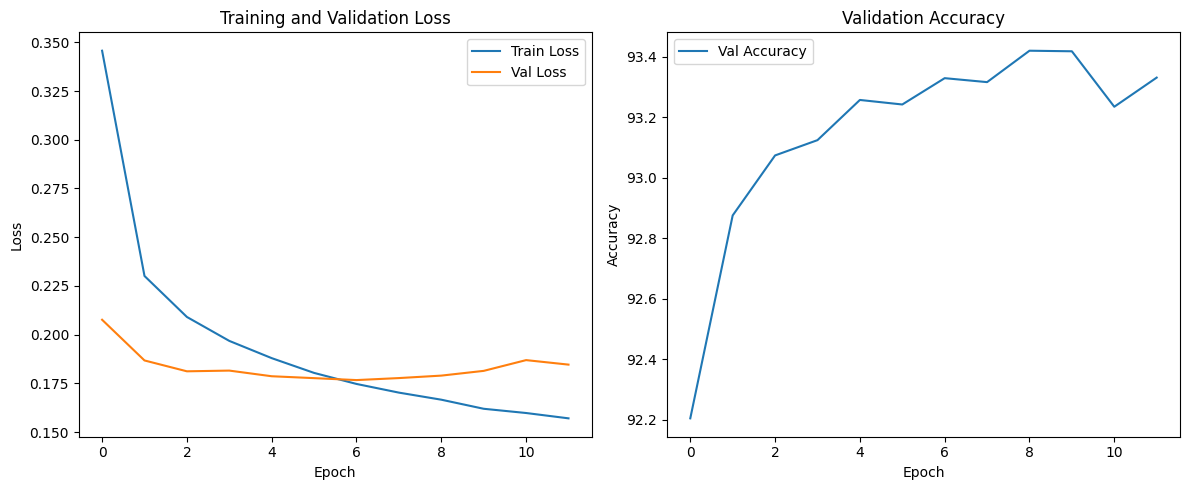

In [38]:
# plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [39]:
# caluclate the test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 93.19%


Top 1 Prediction: Z with output value 5.30775785446167
Top 2 Prediction: 2 with output value 4.500789642333984
Top 3 Prediction: 7 with output value 3.0609636306762695
Top 4 Prediction: I with output value -4.7337422370910645
Top 5 Prediction: T with output value -5.303497791290283
True Label: Z, Predicted Label: Z


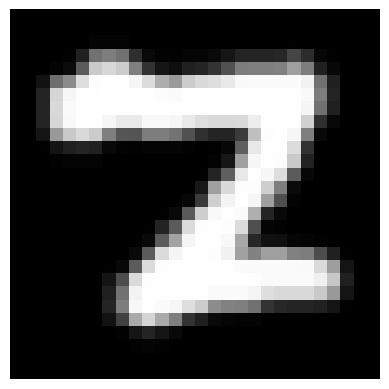

In [40]:
# plot one test sample and push through the model and display the result
model.eval()
with torch.no_grad():
    # random number from the size of the test_data_loader
    random_index = np.random.randint(0, len(data_test_filtered))
    image, label = data_test_filtered[random_index]

    output = model(image.unsqueeze(0))
    # give out the 5 most likely predictions
    top5_prob, top5_catid = torch.topk(output.data, 5)
    for i in range(5):
        print(f"Top {i+1} Prediction: {labels_map[int(top5_catid[0][i])]} with output value {top5_prob[0][i].item()}")

    print(f'True Label: {labels_map[label]}, Predicted Label: {labels_map[int(torch.argmax(output))]}')

    # plot
    image = image.numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')


In [41]:
# load the train and test data and labels from LP_data directory

data_train = torch.load('./LP_data/train/license_plate_train_data.pt')
labels_train = torch.load('./LP_data/train/license_plate_train_labels.pt')
data_test = torch.load('./LP_data/test/license_plate_test_data.pt')
labels_test = torch.load('./LP_data/test/license_plate_test_labels.pt')

In [42]:
# make data loaders for the LP data
train_dataset = torch.utils.data.TensorDataset(data_train, labels_train)
test_dataset = torch.utils.data.TensorDataset(data_test, labels_test)

# split the train set into train:val=80:20
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

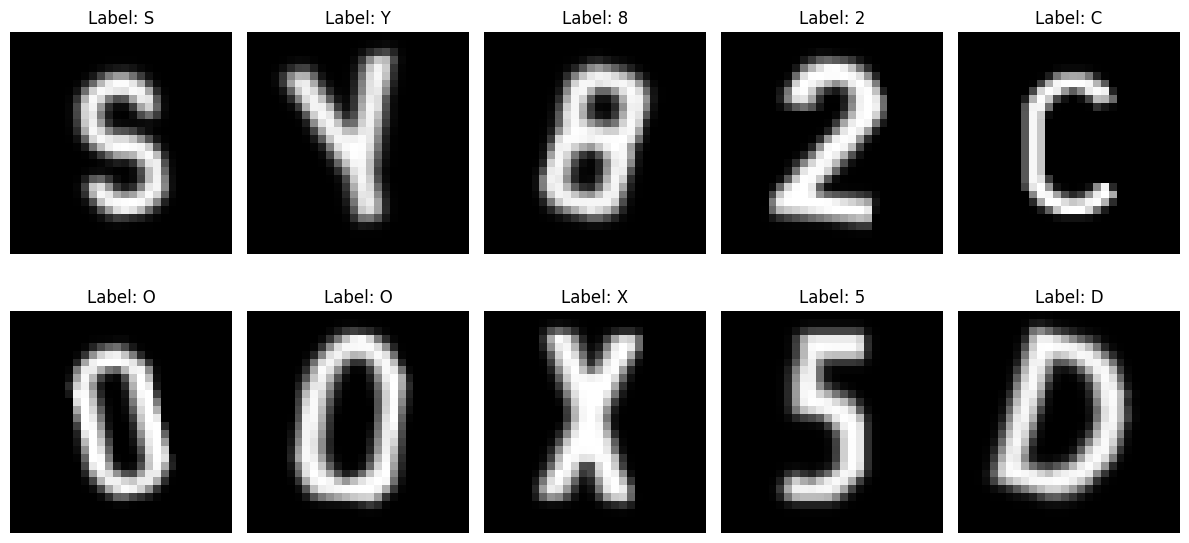

In [43]:
# plot 10 random sampels from the LP dataset
indices = np.random.choice(len(data_train), 10, replace=False)
labels = [labels_train[i] for i in indices]
samples = [data_train[i] for i in indices]
# Plot the samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i, image in enumerate(samples):
    # Denormalize the image
    image = image.numpy().squeeze()
    image = (image * 0.5) + 0.5  # Reverse normalization
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {labels_map[labels[i].item()]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [44]:
# continue trainin the model on the LP data
train_losses, val_losses, val_accuracies = training_loop(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch [1/100], Train Loss: 0.1598, Val Loss: 0.0699, Val Accuracy: 96.92%
Epoch [2/100], Train Loss: 0.0782, Val Loss: 0.0575, Val Accuracy: 97.41%
Epoch [3/100], Train Loss: 0.0682, Val Loss: 0.0540, Val Accuracy: 97.55%
Epoch [4/100], Train Loss: 0.0621, Val Loss: 0.0513, Val Accuracy: 97.70%
Epoch [5/100], Train Loss: 0.0564, Val Loss: 0.0506, Val Accuracy: 97.59%
Epoch [6/100], Train Loss: 0.0543, Val Loss: 0.0440, Val Accuracy: 98.01%
Epoch [7/100], Train Loss: 0.0515, Val Loss: 0.0448, Val Accuracy: 97.81%
Epoch [8/100], Train Loss: 0.0491, Val Loss: 0.0456, Val Accuracy: 98.06%
Epoch [9/100], Train Loss: 0.0483, Val Loss: 0.0430, Val Accuracy: 97.94%
Epoch [10/100], Train Loss: 0.0445, Val Loss: 0.0395, Val Accuracy: 98.11%
Epoch [11/100], Train Loss: 0.0438, Val Loss: 0.0402, Val Accuracy: 98.13%
Epoch [12/100], Train Loss: 0.0435, Val Loss: 0.0391, Val Accuracy: 98.45%
Epoch [13/100], Train Loss: 0.0410, Val Loss: 0.0366, Val Accuracy: 98.26%
Epoch [14/100], Train Loss: 0.0405

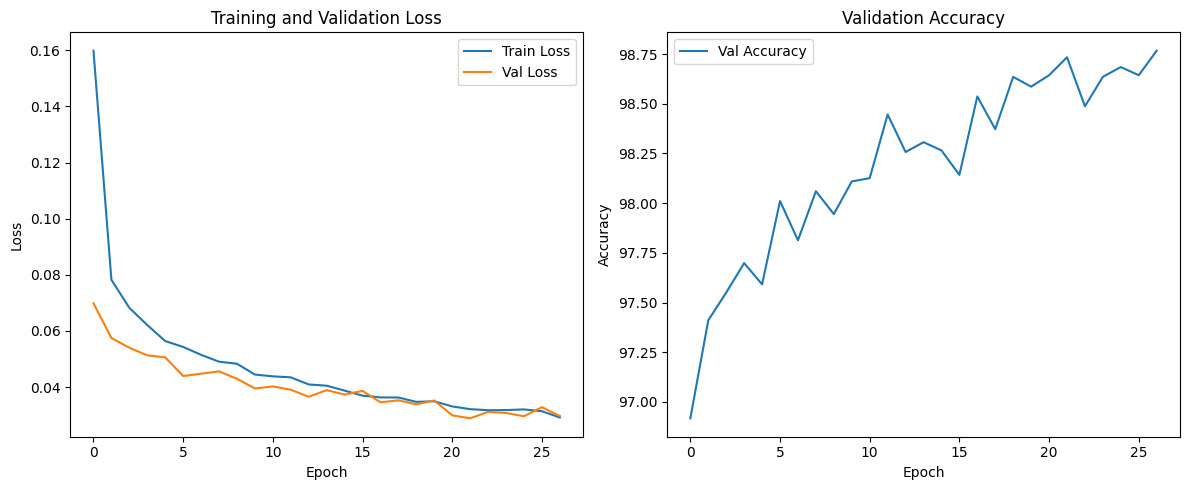

In [45]:
# plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [46]:
# caluclate the test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.78%


Top 1 Prediction: Z with output value 1.0
Top 2 Prediction: 7 with output value 1.85818277431693e-10
Top 3 Prediction: 2 with output value 3.9039732275918115e-13
Top 4 Prediction: L with output value 6.885672706248873e-16
Top 5 Prediction: 1 with output value 2.997714980688585e-16
True Label: Z, Predicted Label: Z


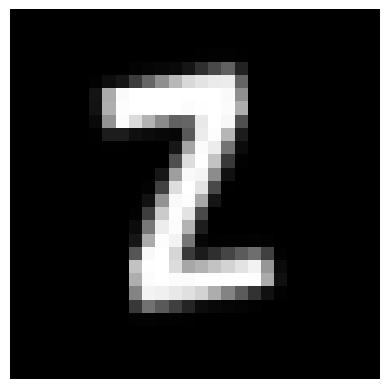

In [49]:
# plot one test sample and push through the model and display the result
model.eval()
with torch.no_grad():
    # random number from the size of the test_data_loader
    random_index = np.random.randint(0, len(train_dataset))
    image, label = train_dataset[random_index]

    output = model(image.unsqueeze(0))
    # give out the 5 most likely predictions

    # soft max the output
    output = torch.softmax(output, dim=1)
    
    top5_prob, top5_catid = torch.topk(output.data, 5)
    for i in range(5):
        print(f"Top {i+1} Prediction: {labels_map[int(top5_catid[0][i])]} with output value {top5_prob[0][i].item()}")

    print(f'True Label: {labels_map[int(label)]}, Predicted Label: {labels_map[int(torch.argmax(output))]}')

    # plot
    image = image.numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
